# Cleaning Modes With Rational Filters

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy

In [4]:
theoretical_values = (68.6, 0.71)

## Data

Download data

In [5]:
home_dir = "./MDC_waveforms/"

In [6]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [7]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

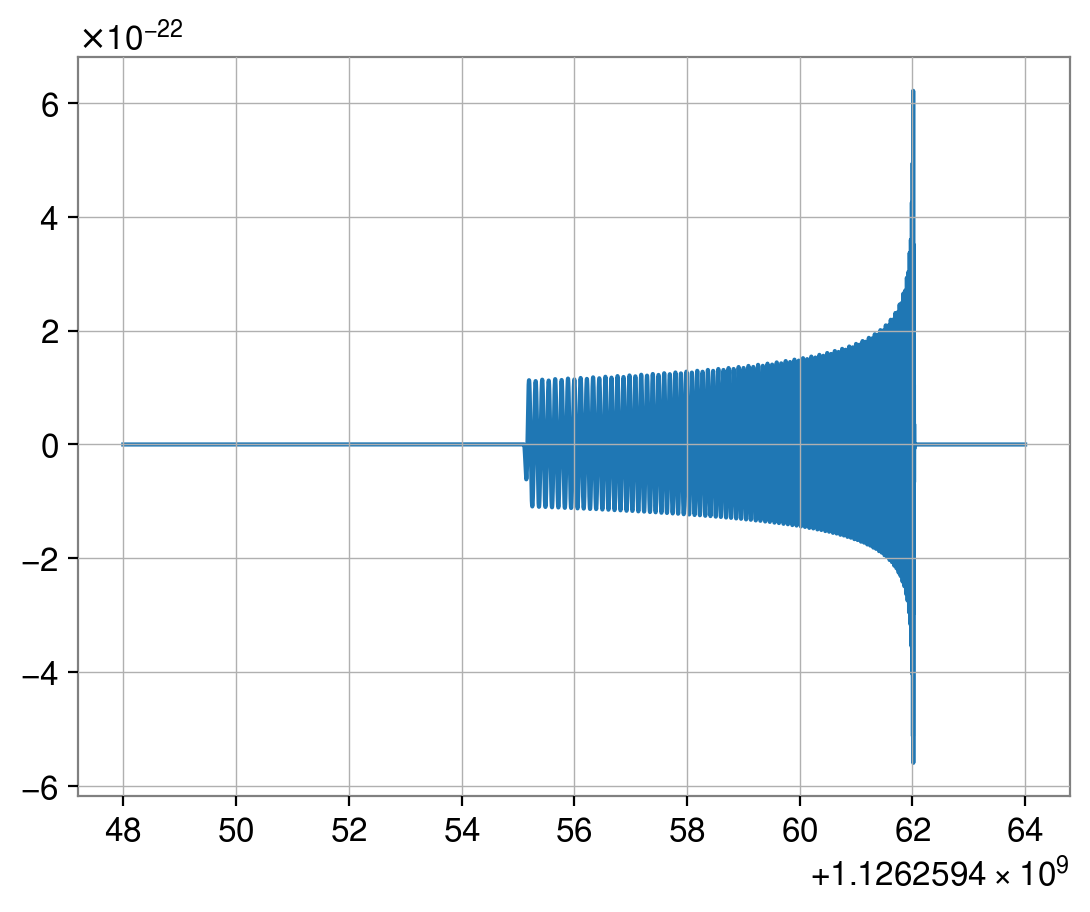

In [8]:
pl.plot(H_data)
# pl.plot(L_data)

In [9]:
H_waveform = qnm_filter.Data(H_data.value, index = H_data.times.value)
L_waveform = qnm_filter.Data(L_data.value, index = L_data.times.value)

In [10]:
peak_time = H_data.times.value[np.argmax(H_waveform)]
SSB_peak_time = peak_time - 0.014685396838313368

In [11]:
SSB_peak_time

1126259461.9987423

## Filter

In [12]:
mass_unit = qnm_filter.Filter.mass_unit(68.6)

In [42]:
input = dict(model_list = [(2,2,0),(2,2,1),(2,2,2),(2,1,0),(3,3,0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = SSB_peak_time+0/2048, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [43]:
fit.original_data['H1'] = H_waveform

In [44]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')

In [45]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 1e-22**2
fit.acfs['H1'] = qnm_filter.Data(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()

In [46]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']

In [47]:
fit.compute_SNR(0, template, 'H1', optimal=True)

14.349463307121491

In [48]:
delta_mass = 1.0
delta_chi = 0.05
massspace = np.arange(34, 140, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [49]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [50]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [51]:
average_mass = np.dot(projected_mass, massspace)
average_chi = np.dot(projected_chi, chispace)
MAP_idx = np.argmax(likelihood_data)
MAP_value = (mass_grid.reshape(-1)[MAP_idx], chi_grid.reshape(-1)[MAP_idx])

In [52]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str((input['t_init'] - SSB_peak_time)/mass_unit)

In [53]:
def epsilon_calc(mass_err, chi_err, mass_theoretical, chi_theoretical):
    temp0 = chi_err**2
    temp1 = (mass_err/mass_theoretical)**2
    return np.sqrt(temp0+temp1)

In [54]:
average_epsilon = epsilon_calc(average_mass - theoretical_values[0], average_chi - theoretical_values[1],
                   theoretical_values[0], theoretical_values[1])
MAP_epsilon = epsilon_calc(MAP_value[0] - theoretical_values[0], MAP_value[1] - theoretical_values[1],
                   theoretical_values[0], theoretical_values[1])

Text(0.5, 1.0, 'Filters: 220+221+222+210+330     t = 0.0$M_f$')

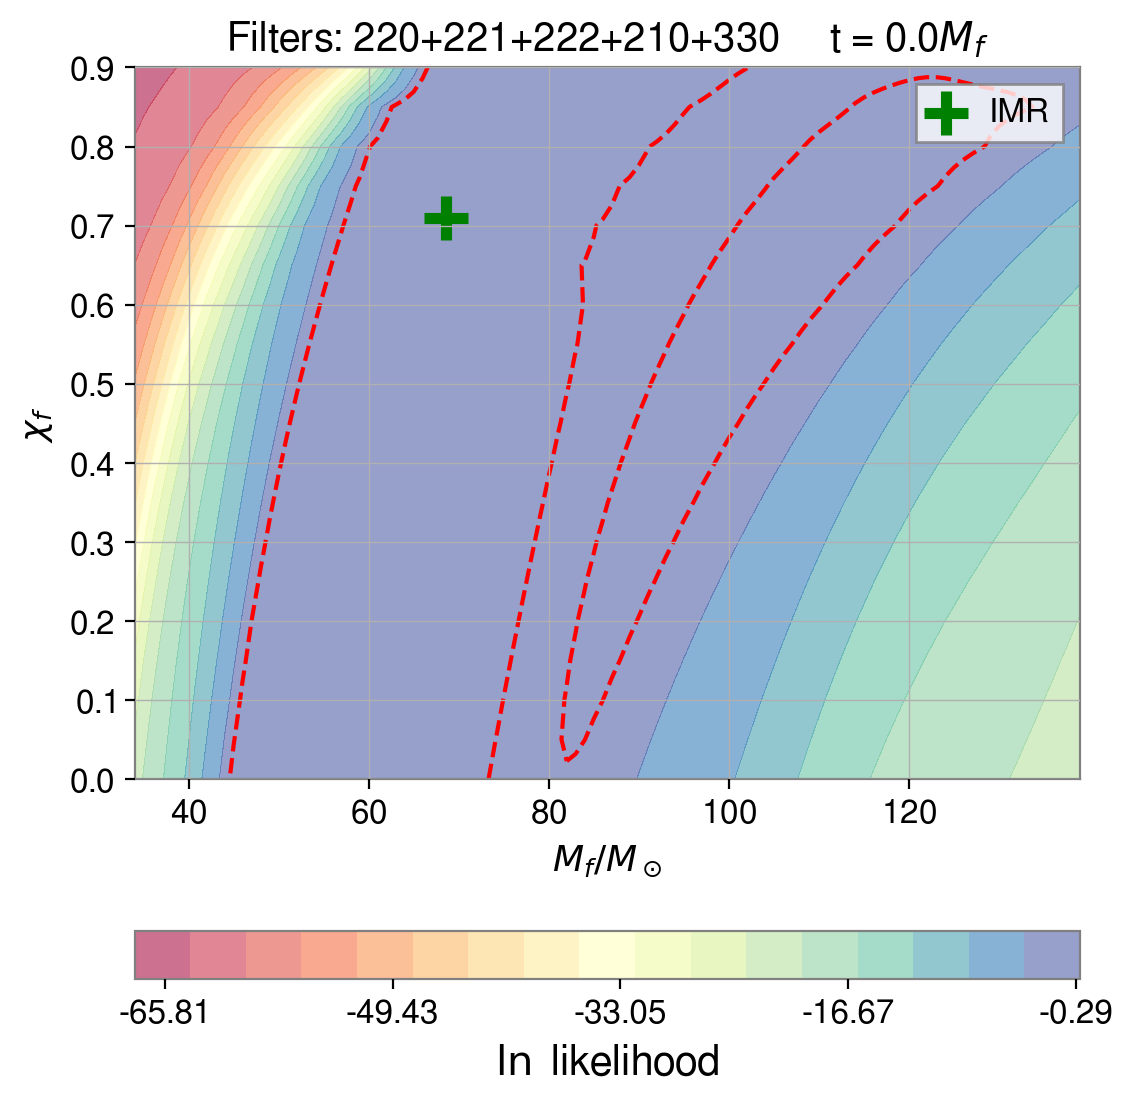

In [55]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='IMR')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))

## Probability vs likelihood in weighting

In [41]:
from scipy.special import logsumexp
evidence = logsumexp(likelihood_data)
normalized_mass = np.exp(logsumexp(likelihood_data, axis=0) - evidence)
normalized_chi = np.exp(logsumexp(likelihood_data, axis=1) - evidence)

In [52]:
test_mass = np.exp(normalized_mass)/np.sum(np.exp(normalized_mass))
test_chi = np.exp(normalized_chi)/np.sum(np.exp(normalized_chi))

test_mass /= delta_mass
test_chi /= delta_chi

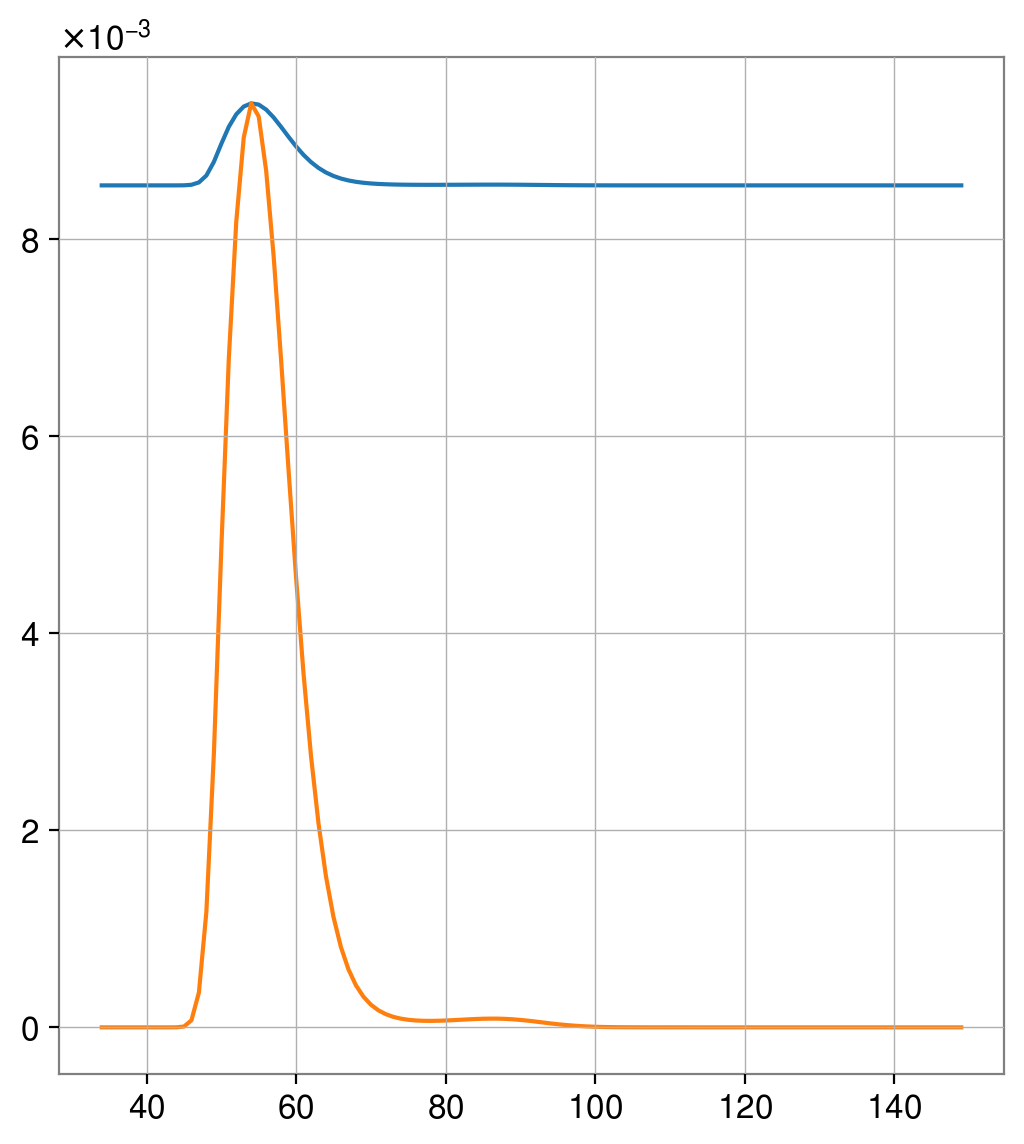

In [57]:
mass_norm = max(test_mass)/max(projected_mass)

pl.plot(massspace, test_mass)
pl.plot(massspace, mass_norm * projected_mass)

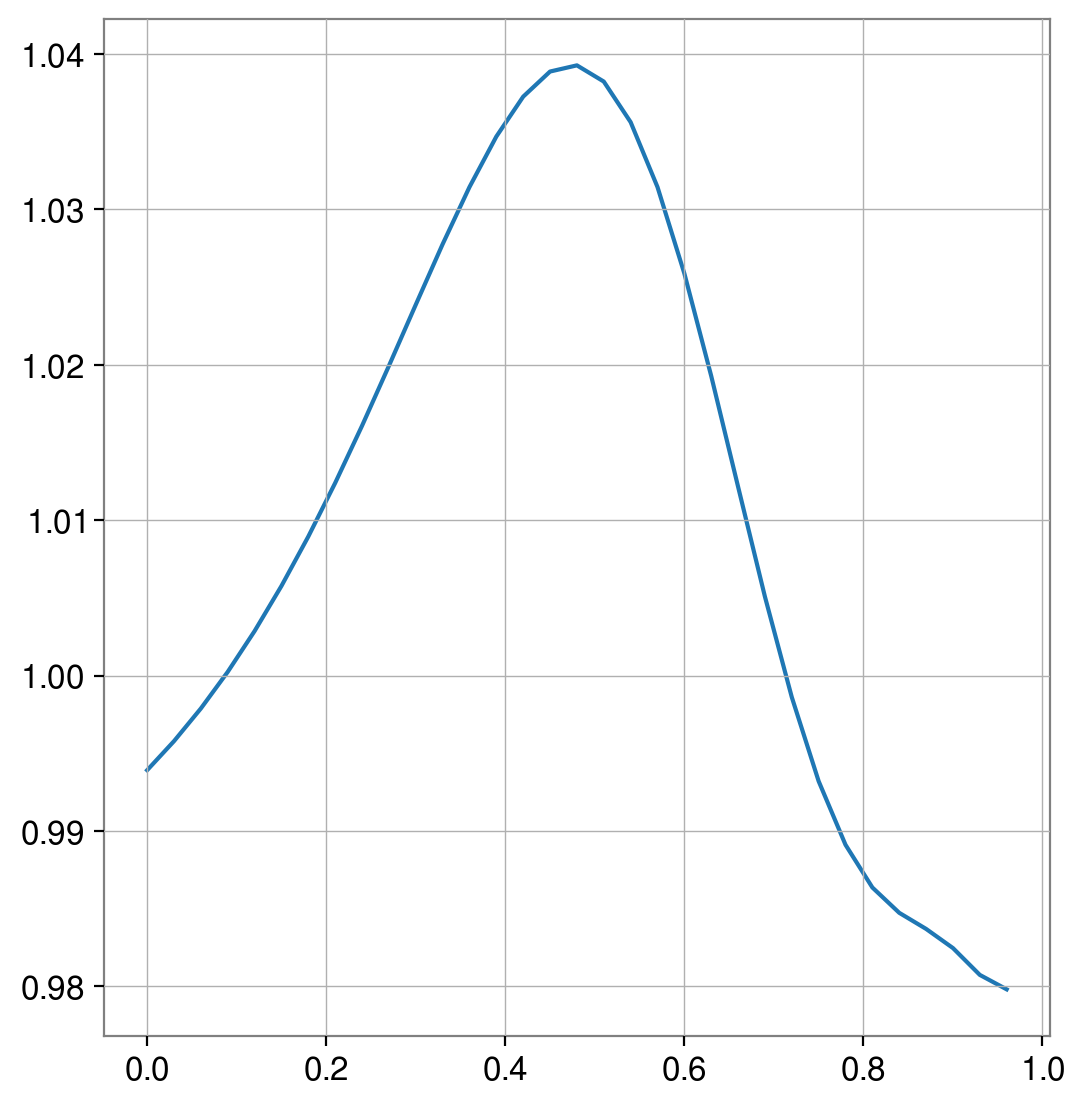

In [55]:
pl.plot(chispace, test_chi)

Text(0, 0.5, '$\\chi_f$')

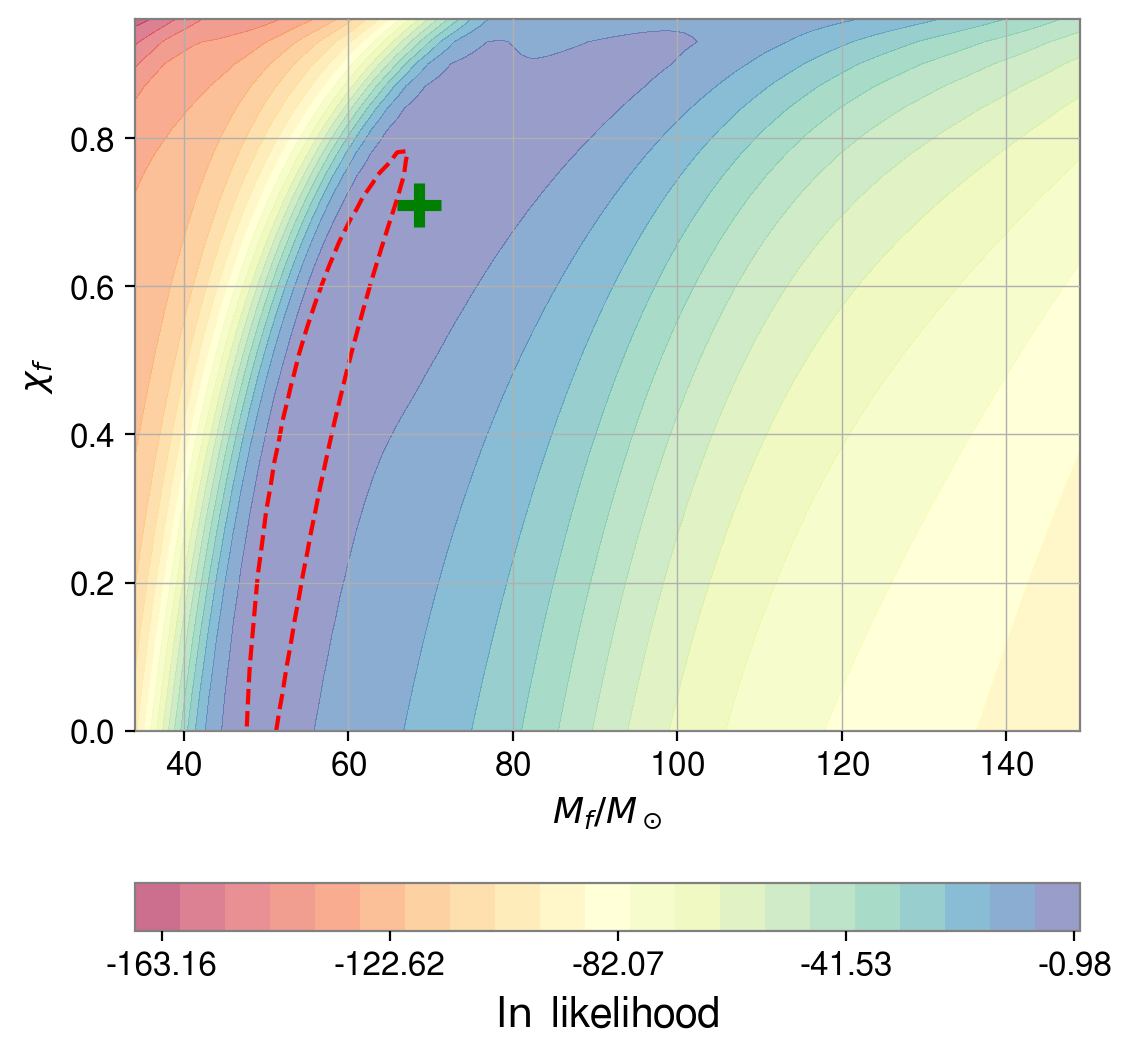

In [28]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.6, y=0.71, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

In [29]:
evidence #120

3.194650224752244

In [30]:
evidence = logsumexp(likelihood_data)
normalized_mass = np.exp(logsumexp(likelihood_data, axis=0) - evidence)
normalized_chi = np.exp(logsumexp(likelihood_data, axis=1) - evidence)

renormalized_mass = normalized_mass/np.sum(normalized_mass * delta_mass)
renormalized_chi = normalized_chi/np.sum(normalized_chi * delta_chi)

NameError: name 'logsumexp' is not defined

In [ ]:
np.sum(normalized_chi * delta_chi)

In [ ]:
delta_chi

In [ ]:
pl.plot(normalized_mass*delta_mass)

In [ ]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [ ]:
projected_chi*chispace

In [ ]:
projected_chi[1]*chispace[1]

In [ ]:
from scipy.special import logsumexp
lg_evidence = logsumexp(likelihood_data)
mass_likelihood = np.exp(logsumexp(likelihood_data, axis=0) - lg_evidence)
mass_likelihood /= np.sum(mass_likelihood * delta_mass)

In [ ]:
pl.plot(massspace, projected_mass)

In [ ]:
pl.plot(chispace, chi_prob, label = "Probability")
pl.plot(chispace, projected_chi, label = "projected_to_1d")
pl.xlabel(r'Mass ($M_\odot$)')
pl.ylabel('"Probability"')
pl.title("Note that both are normalised")
pl.legend()

In [ ]:
pl.plot(massspace, mass_prob, label = "Probability")
pl.plot(massspace, projected_mass, label = "projected_to_1d")
pl.xlabel(r'Mass ($M_\odot$)')
pl.ylabel('"Probability"')
pl.title("Note that both are normalised")
pl.legend()

In [ ]:
# Probability = e**likelihood = e**(e**ln likelihood)
# Normalise probability 
# Average = probability*mass / chi
# Distance = epsilon definition from paper
# Expand M and chi region - before running on cluster

In [ ]:
220, 221, 222, 210, 440, 330

In [ ]:
import qnm
qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=0.71)[0]

In [ ]:
qnm.modes_cache(s=-2, l=2, m=1, n=0)(a=0.71)[0]